In [28]:
import copy
import random
#import shutil
from collections import defaultdict
#from urllib.request import urlretrieve

import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

import albumentations as A
import albumentations.augmentations
#import albumentations.augmentations.functional as F
import ternausnet.models
import torch
import torch.optim
from albumentations.pytorch import ToTensorV2
from torch import nn
from torch.backends import cudnn
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import BinaryJaccardIndex
from tqdm import tqdm

cudnn.benchmark = True

In [2]:
torch.cuda.is_available() # False
torch.mps.is_available() # True
torch.cpu.is_available() # True

True

In [86]:
# Constants for image dimensions
HEIGHT = 1400
WIDTH = 875

PADDED_HEIGHT = 1408
PADDED_WIDTH = 896

# Function for run-length decoding
def rl_decode(enc):
    parts = [int(s) for s in enc.split(' ')]
    dec = list()
    for i in range(0, len(parts), 2):
        cnt = parts[i]
        val = parts[i + 1]
        dec += cnt * [val]
    return np.array(dec, dtype=np.uint8).reshape((HEIGHT, WIDTH))

In [4]:
# setup data directories
root_directory = os.path.join("../datasets")
masks_directory = root_directory

train_images_directory = os.path.join(root_directory, 'train')
test_images_directory = os.path.join(root_directory, 'test')

train_mask_csv = os.path.join(masks_directory, 'train.csv')
test_mask_csv = os.path.join(masks_directory, 'test.csv')

# extract filenames
images_filenames = sorted(os.listdir(train_images_directory))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(train_images_directory, i)) is not None]

test_images_filenames = sorted(os.listdir(test_images_directory))
correct_test_filenames = [i for i in test_images_filenames if cv2.imread(os.path.join(test_images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

# split data filenames
train_images_filenames = correct_images_filenames[0:13]
val_images_filenames = correct_images_filenames[13:]
test_images_filenames = correct_test_filenames

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))


13 4 10


In [ ]:
class LeafDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory

        self.annotations = pd.read_csv(masks_directory + "/train.csv")
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Assuming the CSV contains two columns: 'id == image_filename' and 'encoded_mask == annotation'
        if image_filename[-4:] == ".jpg":
            image_filename = image_filename[:-4]
        encoded_mask_df = self.annotations[self.annotations['id'] == image_filename]
        if encoded_mask_df.empty:
            raise ValueError(f"No segmentation data found for {image_filename} in the CSV.")

        encoded_mask = encoded_mask_df['annotation'].values[0]
        mask = rl_decode(encoded_mask)

        mask = mask.astype(np.float32)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask
    

In [60]:
class LeafInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size


In [ ]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=PADDED_HEIGHT, min_width=PADDED_WIDTH, border_mode=cv2.BORDER_CONSTANT),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ],
    strict=True,
    seed=137,
)
train_dataset = LeafDataset(train_images_filenames, train_images_directory, masks_directory, transform=train_transform)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=PADDED_HEIGHT, min_width=PADDED_WIDTH, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ],
    strict=True,
    seed=137,
)
val_dataset = LeafDataset(val_images_filenames, train_images_directory, masks_directory, transform=val_transform)


/Users/jjohnson99/Projects/Machine_Learning/Leaf-Segmentation/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
test_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=PADDED_HEIGHT, min_width=PADDED_WIDTH, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ],
)
test_dataset = LeafInferenceDataset(test_images_filenames, test_images_directory, transform=test_transform)


In [63]:
def display_test_image_grid(images_filenames, images_directory, predicted_masks=None):
    cols = 2 if predicted_masks else 1
    rows = len(images_filenames)
    _, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i, 0].imshow(image)
        ax[i, 0].set_title("Image")
        ax[i, 0].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 1].imshow(predicted_mask, interpolation="nearest")
            ax[i, 1].set_title("Predicted mask")
            ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

In [7]:
def visualize_augmentations(dataset, idx=0, samples=3):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    _, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()
    

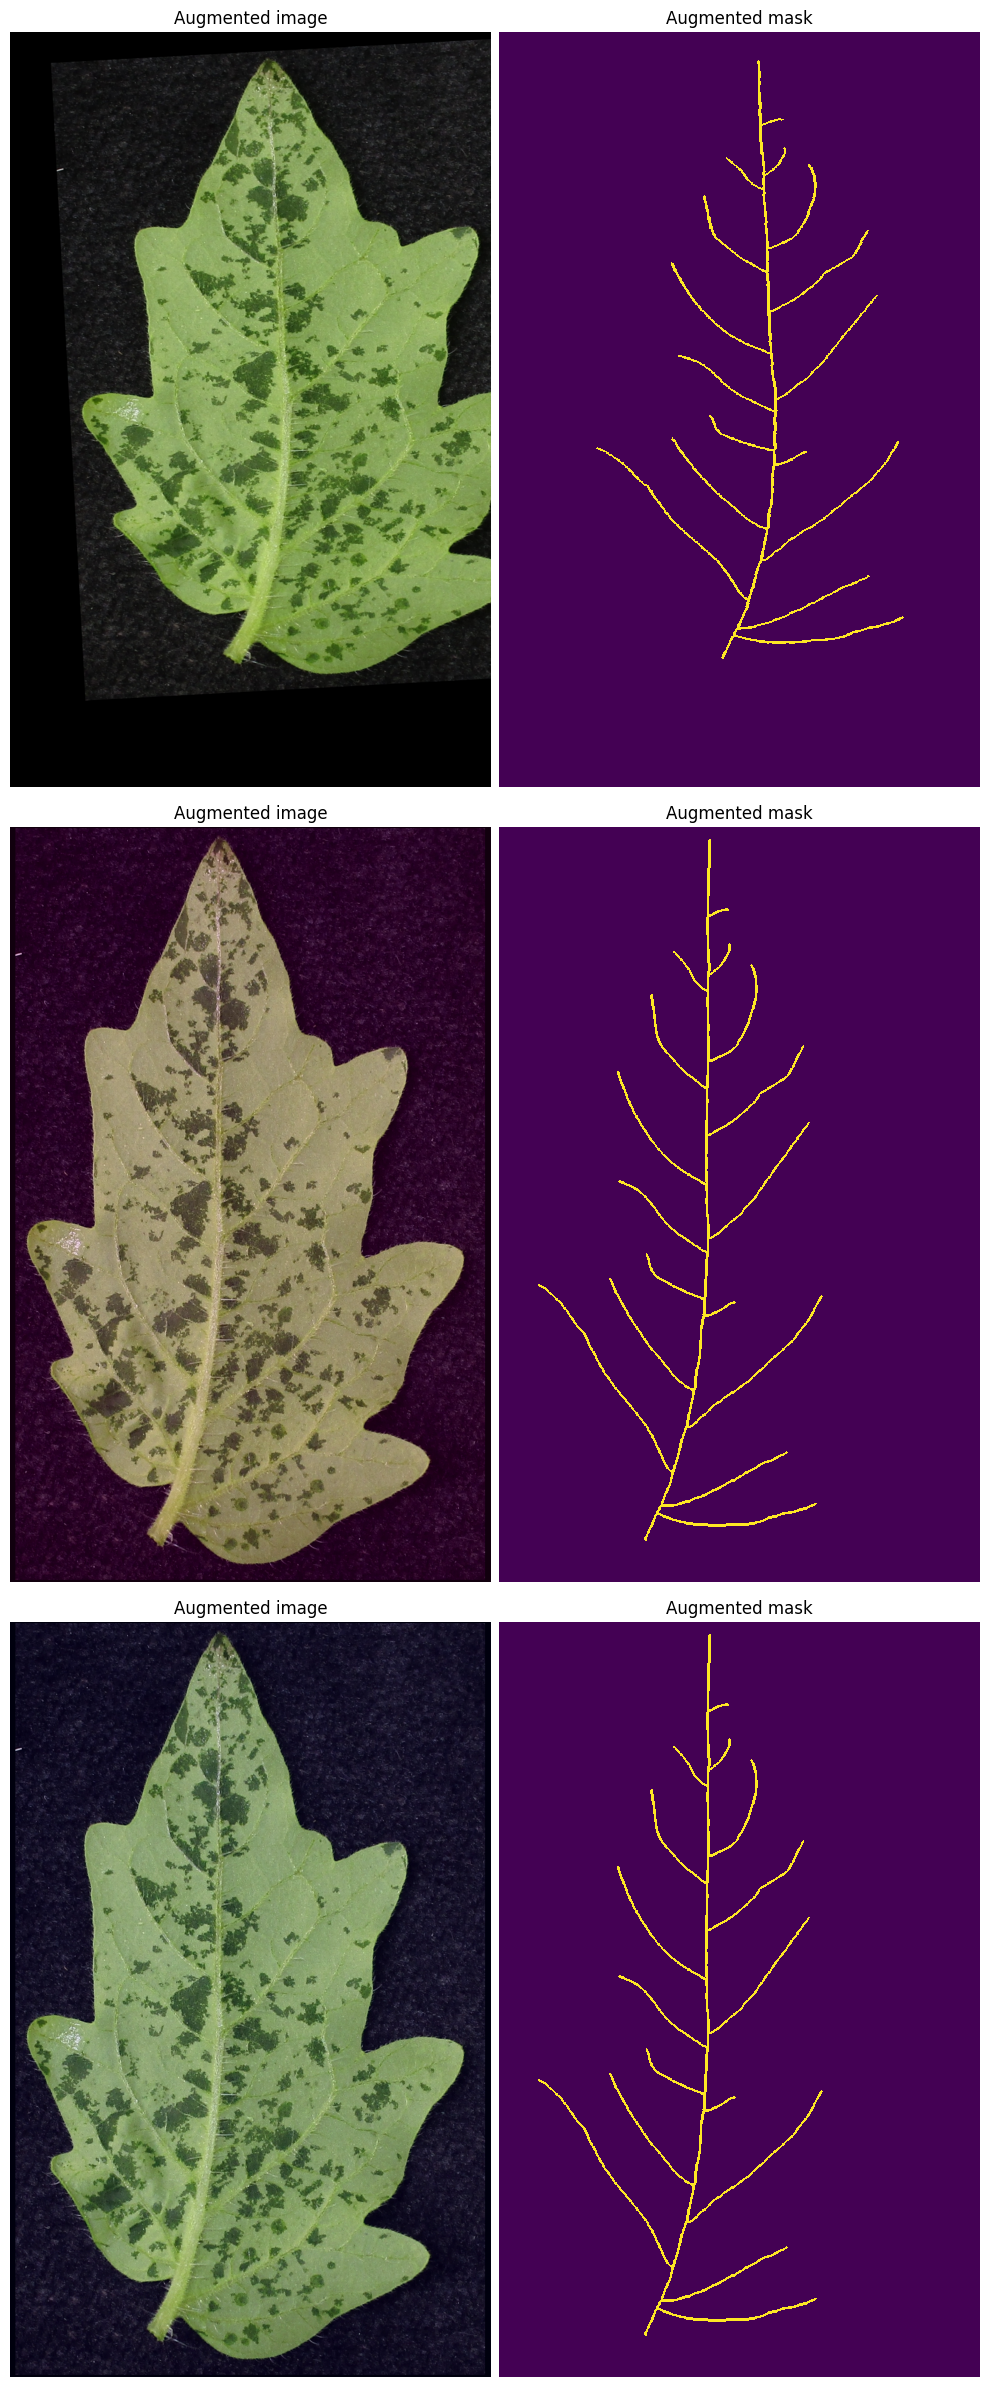

In [85]:
random.seed(42)
visualize_augmentations(train_dataset, idx=0)

In [9]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name,
                    avg=metric["avg"],
                    float_precision=self.float_precision,
                )
                for (metric_name, metric) in self.metrics.items()
            ],
        )


In [79]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for _, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.requires_grad = True
        loss.backward()
        optimizer.step()
        stream.set_description(
            f"Epoch: {epoch}. Train.      {metric_monitor}",
        )


In [11]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for _, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                f"Epoch: {epoch}. Validation. {metric_monitor}",
            )


In [12]:
def create_model(params):
    model = getattr(ternausnet.models, params["model"])(pretrained=True)
    return model.to(params["device"])


In [87]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        #num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        #num_workers=params["num_workers"],
        pin_memory=True,
    )
    #criterion = nn.BCEWithLogitsLoss().to(params["device"])
    criterion = (1 - BinaryJaccardIndex()).to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model


In [58]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        #num_workers=params["num_workers"],
        pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks,
                original_heights.numpy(),
                original_widths.numpy(),
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions


In [81]:
params = {
    "model": "UNet11",
    "device": "mps",
    "lr": 0.001,
    "batch_size": 2,
    #"num_workers": 4,
    "epochs": 10,
}


In [88]:
model = create_model(params)
model = train_and_validate(model, train_dataset, val_dataset, params)


/Users/jjohnson99/Projects/Machine_Learning/Leaf-Segmentation/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jjohnson99/Projects/Machine_Learning/Leaf-Segmentation/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/7 [00:00<?, ?it/s]/Users/jjohnson99/Projects/Machine_Learning/Leaf-Segmentation/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memor

In [92]:
predictions = predict(model, params, test_dataset, batch_size=2)


/Users/jjohnson99/Projects/Machine_Learning/Leaf-Segmentation/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


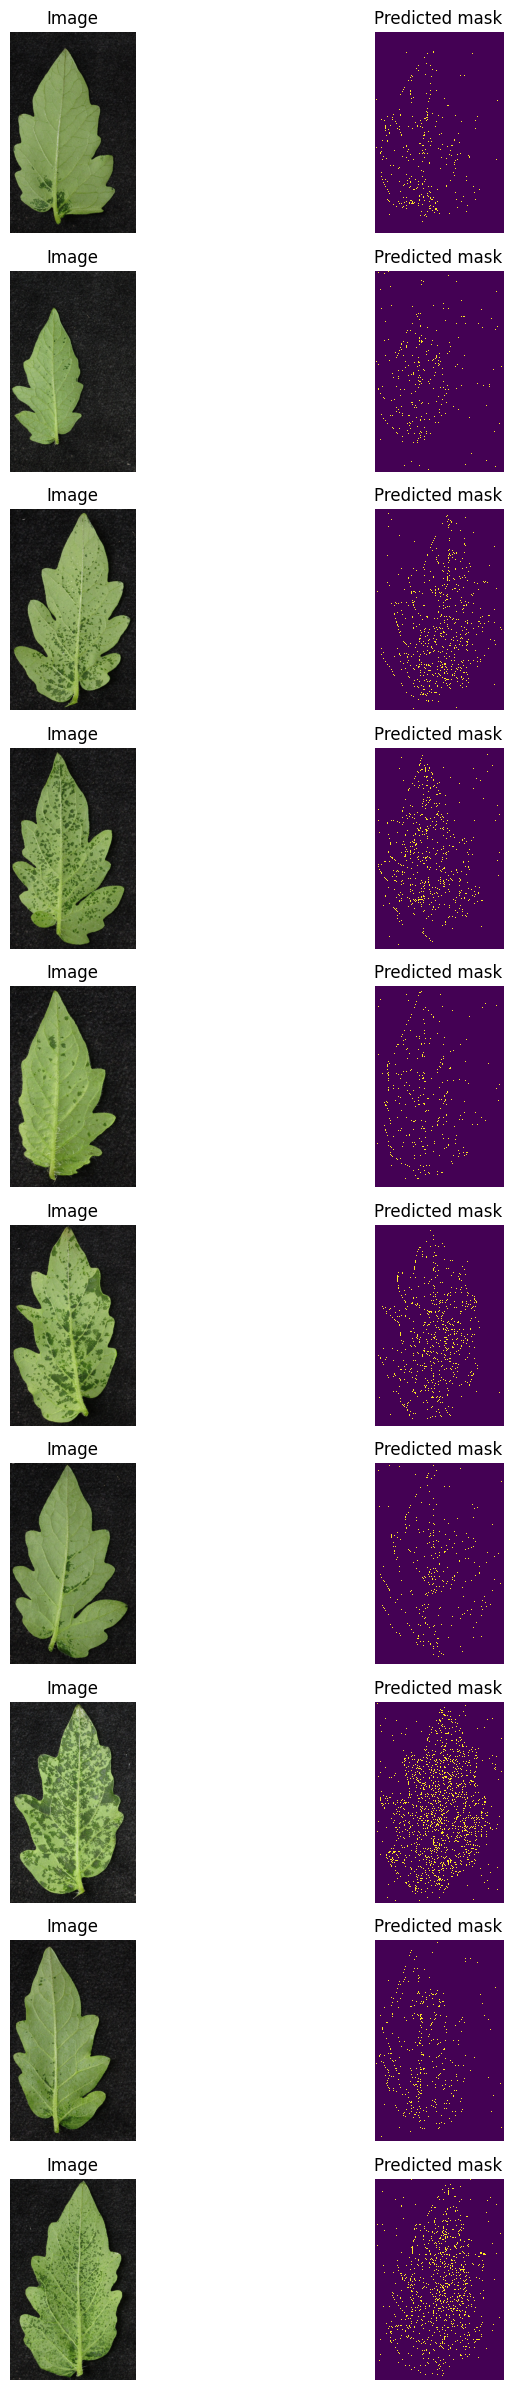

In [93]:
predicted_masks = []
for predicted_padded_mask, original_height, original_width in predictions:
    #cropped_mask = F.center_crop(predicted_padded_mask, original_height, original_width)
    predicted_masks.append(predicted_padded_mask)

display_test_image_grid(test_images_filenames, test_images_directory, predicted_masks=predicted_masks)